In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.distributions import beta, norm
import numpy as np

## Lire les données et créer les colonnes nécessaires

In [2]:
path = "at_home_test_data_study_centers_201909.csv"
df = pd.read_csv(path)
df["device_local_date"] = pd.to_datetime(df["device_local_date"], format="%Y-%m-%d %H:%M:%S")

df["device_local_time"] = df["device_local_date"].dt.time
df["device_local_time"] = pd.to_datetime(df["device_local_time"], format="%H:%M:%S")
df["day_of_week"] =  df["device_local_date"].dt.day_name().astype("category")
df["day_of_week"] = df["day_of_week"].cat.reorder_categories(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# Create total elapsed time in various formats
df["total_seconds"] = df["device_local_date"].dt.hour * 3600 + df["device_local_date"].dt.minute * 60 + df["device_local_date"].dt.second
df["hours"] = df["total_seconds"]/(3600)
df["scaled_time"] = df["hours"]/(24)
df.head()

,shopping_center_id,device_local_date,device_hash_id,device_local_time,day_of_week,total_seconds,hours,scaled_time
0,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-14 10:00:25,6fdffac307,1900-01-01 10:00:25,Saturday,36025,10.006944,0.416956
1,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-14 17:13:15,386141ebd8,1900-01-01 17:13:15,Saturday,61995,17.220833,0.717535
2,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-14 09:07:06,b06242b848,1900-01-01 09:07:06,Saturday,32826,9.118333,0.379931
3,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-14 17:14:49,c13cc52e82,1900-01-01 17:14:49,Saturday,62089,17.246944,0.718623
4,599cb959-11ef-49aa-9eb3-e6c17b4ea6ba,2019-09-14 10:17:35,f339ddf999,1900-01-01 10:17:35,Saturday,37055,10.293056,0.428877


In [3]:
df.dtypes

shopping_center_id            object
device_local_date     datetime64[ns]
device_hash_id                object
device_local_time     datetime64[ns]
day_of_week                 category
total_seconds                  int64
hours                        float64
scaled_time                  float64
dtype: object

## Analyse
Vérifier quelles sont les premières entrées chaque jour, pour chaque magasin, mais puisque les magasins restent ouverts après minuit on va devoir utiliser une solution plus robuste.

In [4]:
df.groupby(["shopping_center_id", "day_of_week"])["device_local_time"].min()

shopping_center_id                    day_of_week
0cd35523-1eca-4f09-ab0d-0b506ae9d986  Monday        1900-01-01 04:00:25
                                      Tuesday       1900-01-01 04:32:53
                                      Wednesday     1900-01-01 04:59:42
                                      Thursday      1900-01-01 02:05:12
                                      Friday        1900-01-01 04:59:22
                                      Saturday      1900-01-01 05:00:40
                                      Sunday        1900-01-01 07:28:36
599cb959-11ef-49aa-9eb3-e6c17b4ea6ba  Monday        1900-01-01 00:07:22
                                      Tuesday       1900-01-01 00:09:34
                                      Wednesday     1900-01-01 00:14:39
                                      Thursday      1900-01-01 00:21:01
                                      Friday        1900-01-01 00:02:10
                                      Saturday      1900-01-01 00:01:20
              

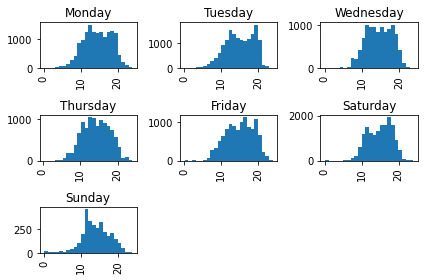

In [5]:
df["hours"].hist(by=df["day_of_week"], bins=24)
plt.tight_layout()

## Solution proposée

Si on arrive à compter chaque intervalle entre deux clients, normalement le premier client de la journée va être celui qui va briser le plus long intervalle sans clients

In [6]:
final_df  = pd.DataFrame()
for i in df["shopping_center_id"].unique():
    # Filter by store
    shop_i = df[df["shopping_center_id"] == i]
    # Sort values
    shop_i = shop_i.sort_values("device_local_date", ascending = True)
    # Get time diff
    shop_i['delta'] = (shop_i['device_local_date']-shop_i['device_local_date'].shift()).fillna(pd.Timedelta('0 days'))
    # Get group
    day_group = shop_i["device_local_date"].dt.floor("d")
    for j in day_group.unique():
        shop_i_day = shop_i[shop_i["device_local_date"].dt.floor("d")==j]
        
        # Get max row
        max_row = shop_i_day.loc[shop_i_day["delta"]==shop_i_day["delta"].max(),:]
        
        # Append the row
        final_df = pd.concat([final_df, max_row], ignore_index=True, sort=False)


final_df.head()

,shopping_center_id,device_local_date,device_hash_id,device_local_time,day_of_week,total_seconds,hours,scaled_time,delta
0,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-01 23:13:48,37839f15ed,1900-01-01 23:13:48,Sunday,83628,23.230000,0.967917,0 days 01:55:53
1,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-02 03:58:14,a1cb49c576,1900-01-01 03:58:14,Monday,14294,3.970556,0.165440,0 days 04:44:26
2,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-03 03:32:23,a1cb49c576,1900-01-01 03:32:23,Tuesday,12743,3.539722,0.147488,0 days 04:47:34
3,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-04 04:15:56,59b9242911,1900-01-01 04:15:56,Wednesday,15356,4.265556,0.177731,0 days 04:09:43
4,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-05 05:12:42,59b9242911,1900-01-01 05:12:42,Thursday,18762,5.211667,0.217153,0 days 07:07:44


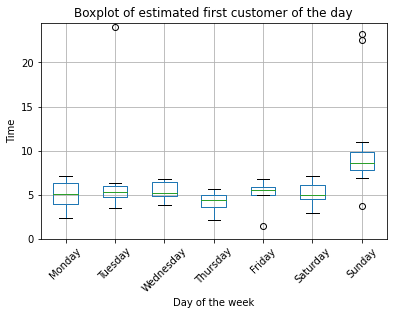

In [7]:
axes = final_df.boxplot(column=['hours'], by='day_of_week')
plt.title("Boxplot of estimated first customer of the day")
plt.suptitle('')
plt.xlabel("Day of the week")
plt.ylabel("Time")
plt.xticks(rotation=45)
plt.ylim(0,24.5)
plt.show()

## Solution Frequentiste - Moins optimal pour ce problème

On sait qu'il y a des valeurs assez extrême vu le box plot, donc une solution fréquentiste est de prendre la médiane de chaque jour, pour chaque magasin. J'ajoute aussi la moyenne pour démontrer que c'est une statistique qui n'est pas fiable à cause des valeurs extrêmes. Malheureusement, je ne trouve pas que cette solution est idéale car on n'a pas beaucoup de données et on peut finir par avoir des résultats biaisés.

In [8]:
print(final_df.groupby(["shopping_center_id", "day_of_week"])["hours"].mean())
print(final_df.groupby(["shopping_center_id", "day_of_week"])["hours"].median())

shopping_center_id                    day_of_week
0cd35523-1eca-4f09-ab0d-0b506ae9d986  Monday          5.337963
                                      Tuesday         4.911574
                                      Wednesday       5.025417
                                      Thursday        3.521528
                                      Friday          5.010833
                                      Saturday        5.017778
                                      Sunday         12.927963
599cb959-11ef-49aa-9eb3-e6c17b4ea6ba  Monday          4.222593
                                      Tuesday        11.861574
                                      Wednesday       6.532917
                                      Thursday        3.819167
                                      Friday          3.487500
                                      Saturday        5.337778
                                      Sunday          9.924722
b43e9e4f-acd1-4941-874d-e0c5650ab91e  Monday          3.813519
     

## Solution Bayesienne

Comme on n'a pas beaucoup de données mais une bonne idée de l'heure dont les magasins ouvrent en France en général, on peut combiner nos connaissances (_a priori_) et nos données pour créer une distribution (_a posteriori_) pour notre valeur estimée.

Je vais créer 2 _a priori_ une pour la semaine, et une pour le weekend. J'ai décidé d'utiliser le modèle Normal-Normal puisque c'est une solution simple et facile à interpréter.

### A Priori en semaine

En semaine je m'attends a ce que les magasins ouvrent plus tot et je suis assez certain de ce fait donc je vais opter pour une moyenne de 6 heure du matin (0.25) et une variance minime (0.005).

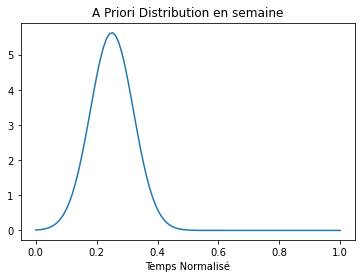

In [9]:
week_mu = 0.25
week_variance = 0.005
x = np.linspace(0, 1, 100)
y1 = norm.pdf(x, week_mu, np.sqrt(week_variance))
plt.plot(x,y1)
plt.title("A Priori Distribution en semaine")
plt.xlabel("Temps Normalisé")
plt.show()

### A Priori en weekend

En weekend je m'attends a ce que les magasins ouvrent plus tard et je suis assez certain de ce fait donc je vais opter pour une moyenne de 8 heure du matin (0.33) et une variance minime (0.005).

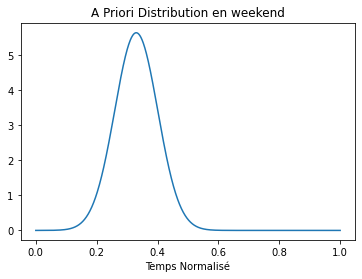

In [10]:
weekend_mu = 0.33
weekend_variance = 0.005
x = np.linspace(0, 1, 1000)
y1 = norm.pdf(x, weekend_mu, np.sqrt(weekend_variance))
plt.plot(x,y1)
plt.title("A Priori Distribution en weekend")
plt.xlabel("Temps Normalisé")
plt.show()

### Données

J'utilise les données pour mettre a jour la moyenne et la variance, et je cree une fonction pour simplifier le code

In [11]:
week_stores = final_df[~ final_df["day_of_week"].isin(["Saturday", "Sunday"])]
weekend_stores = final_df[final_df["day_of_week"].isin(["Saturday", "Sunday"])]

In [12]:
def update_parmeters(df, priori_mu, priori_variance):
    n = df.shape[0]
    observations = df["scaled_time"]
    observed_variance = np.var(observations)
    mu_updated = ((priori_mu/priori_variance) + (np.sum(observations)/observed_variance))/((1/priori_variance)+(n/observed_variance))
    variance_updated = 1/((1/priori_variance) + (n/observed_variance))
    return mu_updated, variance_updated

### A Posteriori en semaine

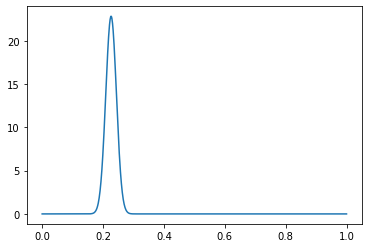

Posterior Mu: 0.22644286487805804
Posterior Variance: 0.00030541696566534655


In [13]:
mu_updated, variance_updated = update_parmeters(week_stores, week_mu, week_variance)

y1 = norm.pdf(x, mu_updated, np.sqrt(variance_updated))
plt.plot(x,y1)
plt.show()

print(f"Posterior Mu: {mu_updated}")
print(f"Posterior Variance: {variance_updated}")

### A Posteriori en weekend

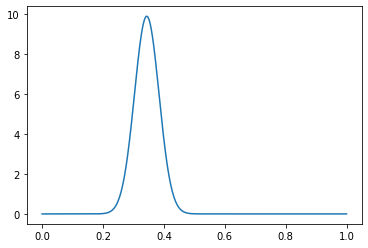

Posterior Mu: 0.34360048195704984
Posterior Variance: 0.0016216782879880948


In [14]:
mu_updated, variance_updated = update_parmeters(weekend_stores, weekend_mu, weekend_variance)

y1 = norm.pdf(x, mu_updated, np.sqrt(variance_updated))
plt.plot(x,y1)
plt.show()

print(f"Posterior Mu: {mu_updated}")
print(f"Posterior Variance: {variance_updated}")

### Algorithme final

`bayesian_estimate` estime l'heure du 1er arrivant

`estimate_to_opening` transforme le résultat précédent à l'heure d'ouverture logique (les magasins n'ouvrent que à XX:30 ou XX:00)

`data_to_opening` combine les deux fonctions précédentes pour donner l'algorithme final

In [15]:
def bayesian_estimate(df, is_weekend, verbose):
    prior_mu = 0.33 if is_weekend else 0.25
    prior_variance = 0.005
    
    if is_weekend:
        filtered_df = df[df["day_of_week"].isin(["Saturday", "Sunday"])]
    else:
        filtered_df = df[~ df["day_of_week"].isin(["Saturday", "Sunday"])]

    # Show plots if verbose
    if verbose:
        x = np.linspace(0, 1, 1000)
        y1 = norm.pdf(x, prior_mu, np.sqrt(prior_variance))
        plt.plot(x,y1)
        plt.xlabel("Temps Normalisé")
        print(f"Prior Mu: {prior_mu}")
        print(f"Prior Variance: {prior_variance}")
    mu_updated, variance_updated = update_parmeters(filtered_df, prior_mu, prior_variance)
    
    if verbose:
        y1 = norm.pdf(x, mu_updated, np.sqrt(variance_updated))
        plt.plot(x,y1)
        plt.legend(["Prior", "Posterior"])
        plt.xlim(0,1)
        plt.title("A Priori and A Posteriori Distribution")
        plt.show()
        print(f"Posterior Mu: {mu_updated}")
        print(f"Posterior Variance: {variance_updated}")
    return mu_updated, variance_updated

def estimate_to_opening(mu, verbose=True):
    hour = int(np.floor(mu*24))
    minutes = ((mu*24) % 1)*60
    minutes_floor = "30" if minutes > 30 else "00"
    opening_time = f"{hour}:{minutes_floor}"
    if verbose:
        print(f"Heure d'ouverture du magasin: {opening_time}")
    return opening_time

def data_to_opening(df):
    week_mu, _ = bayesian_estimate(df, False, False)
    weekend_mu, _ = bayesian_estimate(df, True, False)
    return estimate_to_opening(week_mu, False), estimate_to_opening(weekend_mu, False)

#### Example de la fonction sur un magasin

Prior Mu: 0.25
Prior Variance: 0.005


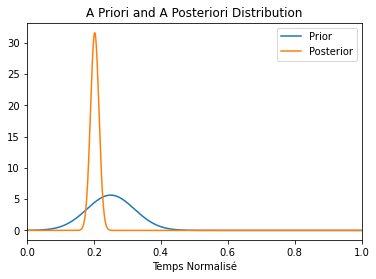

Posterior Mu: 0.20248157446881865
Posterior Variance: 0.00015935628615920447
Heure d'ouverture du magasin: 4:30


In [16]:
final_mu,_ = bayesian_estimate(final_df[final_df["shopping_center_id"]=="0cd35523-1eca-4f09-ab0d-0b506ae9d986"], False, True)
opening_time = estimate_to_opening(final_mu)

### Resultats

La première valeur est l'ouverture approximée en semaine, et la deuxième en weekend.

In [17]:
final_df.groupby("shopping_center_id").apply(data_to_opening)

shopping_center_id
0cd35523-1eca-4f09-ab0d-0b506ae9d986    (4:30, 8:00)
599cb959-11ef-49aa-9eb3-e6c17b4ea6ba    (6:00, 8:00)
b43e9e4f-acd1-4941-874d-e0c5650ab91e    (4:30, 8:00)
cb2d5bb6-c372-4a51-8231-4ffa288a0c28    (5:30, 7:00)
dtype: object

## Comment ameliorer l'algorithme

Il y a plusieurs manières d'améliorer nos predictions

- Récolter plus de données pour mieux mettre à jour notre _a priori_
- Avoir plus d'informations sur les magasins, pour créer des _a priori_ plus rigide
- Utiliser un modèle plus logique que Normal-Normal car les valeurs ne peuvent pas réelement sortir de l'intervalle $[0,1)$ mais le modèle que j'utilise a un intervalle de $(-\infty , \infty )$